In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import h5py
from dataPython import *
import scipy.interpolate as inter
import scipy.integrate as integrate
import scipy.optimize as optimize

The purpose of this is to get the PuBe distribution from the paper: Phys. Rev. **98** 40 (1955) and plot the points and turn it into a spline fit like the one shown here:

https://stackoverflow.com/questions/17913330/fitting-data-using-univariatespline-in-scipy-python

In [2]:
#a function to get three rows of data x y yerr
data = getXYdata_wYerr('data/pube_points.dat')

#print(data)


Now try fitting this data with a spline based on the SO post above.


In [3]:
#spline interpolation
s1 = inter.InterpolatedUnivariateSpline (data['xx'], data['yy'])
#spline fit
s2 = inter.UnivariateSpline (data['xx'], data['yy'], s=1.5)

#store the integral
s2_norm = integrate.quad(lambda x: s2(x), 0, optimize.brentq(s2,9,13))
dx=0.01
#X  = np.arange(0,optimize.brentq(s2,9,13)+dx,dx)
X  = np.arange(0,13,dx)
s2_disc = s2(X)
s2_disc[s2_disc<0] = 0
s2_norm2 = np.sum(dx*s2_disc)
print(s2_norm)
print(s2_norm2)
print(np.shape(s2_disc))

#define a piecewise function for the spline
ul = optimize.brentq(s2,9,13)
#print(ul)
a = lambda x: np.sqrt(x)
s2_cutoff = lambda x: np.piecewise(x, [x < ul, x >= ul], [s2(x[x<ul])/s2_norm[0],0])
s2_cutoff_cdf = lambda x: integrate.quad(s2_cutoff,0,x)
#print([s2_cutoff(X),X])
#print(s2_cutoff(X))
#print(a(X))

(68.25527943592249, 7.528535621810767e-07)
68.2798772702
(1300,)


In [4]:
#trying to customize here, see:
#https://matplotlib.org/users/customizing.html
#matplotlib.rc('figure', figsize=(3.4, 3.4*(4/6)))
mpl.rcParams['lines.linewidth'] = 2

#ticks
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.labelsize'] = 22

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 22

#error bars
#mpl.rcParams['errorbar.capsize'] = 3

#axis stuff
mpl.rcParams['axes.labelsize'] = 22

#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

In [5]:
#set up a plot
fig,axes = plt.subplots(2,1,figsize=(9.0,12.0))
ax1 = axes[0]
ax2 = axes[1]

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)

ax1.errorbar(data['xx'], data['yy'], yerr=data['ey'],marker='o', markersize=8, linestyle='none',color='k', label='data')
#xx = np.arange(0,13,dx)
ax1.plot (X, s1(X), 'k--', label='Spline, interpolation')
ax1.plot (X, s2(X), 'r-', label='Spline, fit')

ax1.set_yscale('linear')
ax1.set_xlim(0, 13)
ax1.set_ylim(0,13)
ax1.set_xlabel('neutron energy [MeV]',**axis_font)
ax1.set_ylabel('neutrons/cm$^2$ MeV',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend([gh,gl,nh,nl], ['gamma (high gain)','gamma (low gain)','neutron (high gain)', 'neutron (low gain)'],loc=1)
#ax1.legend(loc=1, bbox_to_anchor=(0.82, 1),
#         fancybox=True, shadow=True, ncol=4)
ax1.legend(loc=1,prop={'size':22})

#ax2.plot (X, s2_disc/s2_norm[0], 'r-', label='Spline, fit, normalized')
ax2.plot (X, s2_cutoff(X), 'r-', label='Spline, fit, normalized')
print(s2_norm)

pdfmax = 0.25
ax2.set_yscale('linear')
ax2.set_xlim(0, 13)
ax2.set_ylim(0,pdfmax)
ax2.set_xlabel('neutron energy [MeV]',**axis_font)
ax2.set_ylabel('norm',**axis_font)
ax2.grid(True)
ax2.yaxis.grid(True,which='minor',linestyle='--')


#make a cumulative histogram too
cdfmax=1.2
ax2_c = ax2.twinx()
ax2.plot (X, np.cumsum(dx*s2_disc)*(pdfmax/cdfmax)/s2_norm2, 'r--', label='Spline, cumulative')
#ax2.plot (X, s2_cutoff_cdf(X), 'r--', label='Spline, cumulative')
#print(np.cumsum(dx*s2_disc/s2_norm[0]))
#print(np.cumsum(dx*s2_disc)*(pdfmax/cdfmax)/s2_norm2)
ax2_c.set_yscale('linear')
ax2_c.set_ylim(0,cdfmax)
ax2_c.set_ylabel('cumulative',**axis_font)
#ax2_c.grid(True)
#ax2_c.yaxis.grid(True,which='minor',linestyle='--')
ax2.legend(loc=2,prop={'size':22})

(68.25527943592249, 7.528535621810767e-07)


In [6]:
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)
  ax2.spines[axis].set_linewidth(2)

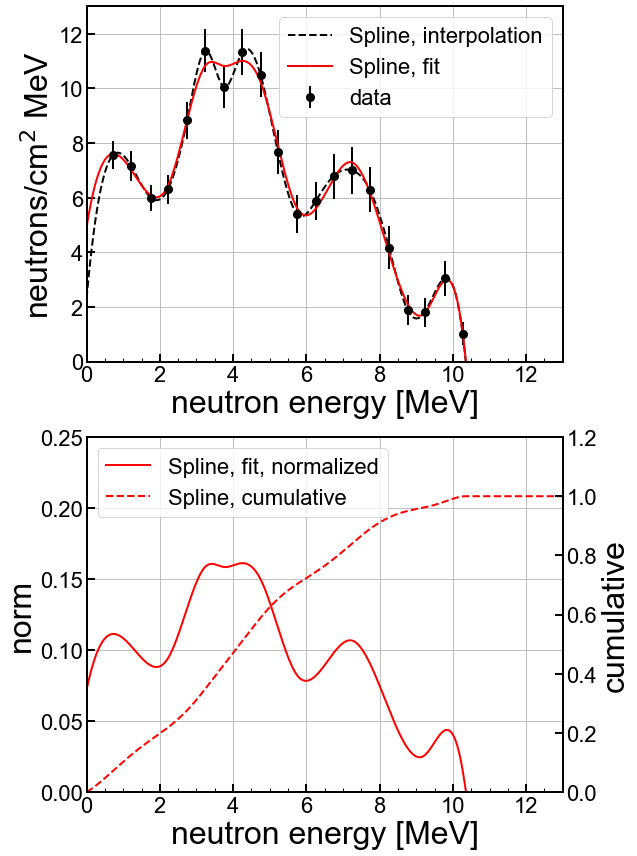

In [7]:
plt.tight_layout()
plt.savefig('figures/pube_replot.eps')
plt.show()


Now I want to use the cumulative distribution function in order to generate neutron energies that follow this fit distribution.  The method would be to generate uniform variables and then transform them by the inverse of the CDF.


In [8]:
#first make a grid of x values
dxmap = 0.1
xmap = np.arange(0,13,dxmap)

yval = s2(xmap)
yval[yval<0] = 0
norm = np.sum(dxmap*yval)
yval = np.cumsum(dxmap*yval)/norm

#print(yval)

#make a spline function
cdf = inter.InterpolatedUnivariateSpline (xmap, yval)

#print(cdf(xmap))

#generate some random numbers
N = 1000000
cdf_vals = np.random.uniform(0,1,N)
pdf_vals = np.zeros(np.shape(cdf_vals))

for i in np.arange(0,N-1,1):
    func = lambda x: cdf(x)-cdf_vals[i]
    pdf_vals[i] = optimize.brentq(func,-0.1,13)
    
#print(pdf_vals)

In [9]:
#set up a plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)

# the histogram of the data
num_bins = 50
n, bins, patches = ax1.hist(pdf_vals, num_bins, normed=1)
ax1.plot (X, s2_cutoff(X), 'r-', label='Spline, fit, normalized')



ax1.set_yscale('linear')
ax1.set_xlim(0, 13)
ax1.set_ylim(1e-2,0.2)
ax1.set_xlabel('neutron energy [MeV]',**axis_font)
ax1.set_ylabel('events',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend([gh,gl,nh,nl], ['gamma (high gain)','gamma (low gain)','neutron (high gain)', 'neutron (low gain)'],loc=1)
#ax1.legend(loc=1, bbox_to_anchor=(0.82, 1),
#         fancybox=True, shadow=True, ncol=4)
#ax1.legend(loc=1,prop={'size':22})

In [10]:
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

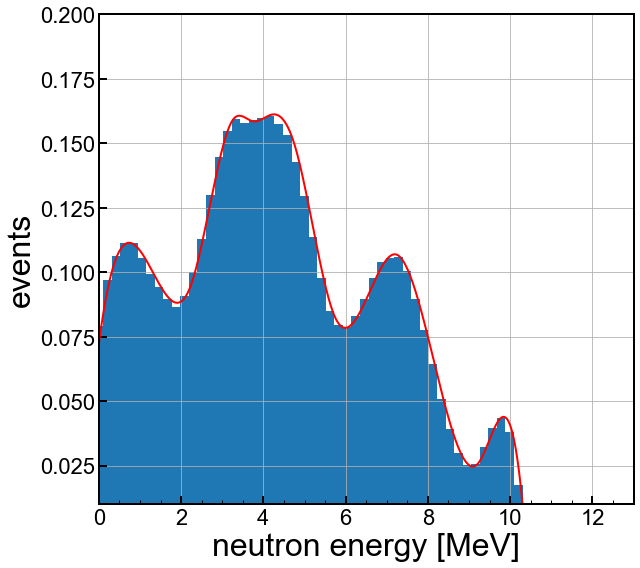

In [11]:
plt.tight_layout()
plt.savefig('figures/pube_gendist.eps')
plt.show()


Now that I have these generated, one million primaries, I can save the values in an hdf5 file so that I can use them to construct a histogram (via ROOT if necessary) to generate this distribution in an external C++ code.  I will also save the cumulative distribution because it makes it easier to make a generator of this distribution without using an external analysis package like ROOT.


In [12]:
#write the vectors to an hdf5 file, everybody's doing it.

f = h5py.File("data/pube_def.hdf5", "w")

#Pu/Be source definition variables
dset_neut_E = f.create_dataset("pube_def_1M/ne", (len(pdf_vals),), dtype='f')
dset_neut_E[...] = pdf_vals
dset_neut_cdf_xx = f.create_dataset("pube_def_1M/ne_cdf/xx", (len(X),), dtype='f')
dset_neut_cdf_yy = f.create_dataset("pube_def_1M/ne_cdf/yy", (len(np.cumsum(dx*s2_disc)*(pdfmax/cdfmax)/s2_norm2),), dtype='f')
dset_neut_cdf_xx[...] = X
dset_neut_cdf_yy[...] = np.cumsum(dx*s2_disc)*(pdfmax/cdfmax)/s2_norm2

f.close()

f = h5py.File("data/pube_def.hdf5","r")

for i in f:
    print(i)

#ax2.plot (X, np.cumsum(dx*s2_disc)*(pdfmax/cdfmax)/s2_norm2, 'r--', label='Spline, cumulative')

pube_def_1M
